<a href="https://colab.research.google.com/github/squishynuggit/What_is_that/blob/main/owen's_WHAT_IS_THAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##**Preprocessing**

In [ ]:
from google.colab import drive
from google.colab import drive

drive.mount('/content/drive/')

IMAGE_PATH = "/content/drive/MyDrive/WHAT_IS_THAT/data/original_images"       #"./data/dataset/semantic_drone_dataset/original_images"
MASK_PATH = "/content/drive/MyDrive/WHAT_IS_THAT/data/label_images_semantic"

Mounted at /content/drive/


## **Dataset**

Total Images:  400
      id
0    002
1    001
2    000
3    011
4    015
..   ...
395  586
396  593
397  587
398  596
399  598

[400 rows x 1 columns]
Train Size   :  320
Val Size     :  40
Test Size    :  40
Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


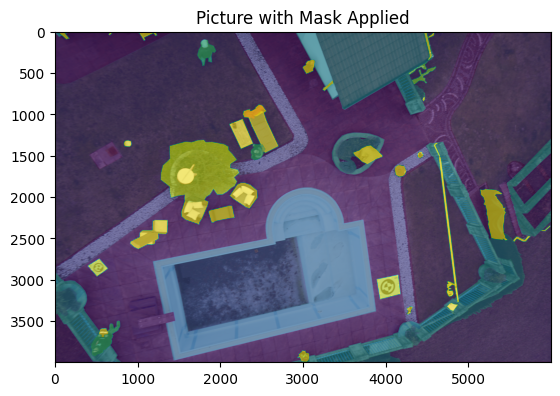

In [ ]:
  n_classes = 23

  def create_df():  # create dataframe
      name = []
      for dirname, _, filenames in os.walk(IMAGE_PATH):
          for filename in filenames:
              name.append(filename.split('.')[0])  # separate the image from jpg or png
              # (for example 000.jpg is appended to the "name" list as "000")

      return pd.DataFrame({'id': name}, index=np.arange(0, len(name)))  # create a pandas dataframe with column "id"


  df = create_df()
  print('Total Images: ', len(df))
  print(df)

  # split data
  X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=0)
  X_train, X_val = train_test_split(X_trainval, test_size=1 / 9, random_state=0)
  # split training/val/test into 60:20:20, can be changed

  print('Train Size   : ', len(X_train))
  print('Val Size     : ', len(X_val))
  print('Test Size    : ', len(X_test))

  img = Image.open(f"{IMAGE_PATH}/{df['id'][4]}.jpg")  # 001.jpg
  mask = Image.open(f"{MASK_PATH}/{df['id'][4]}.png")
  print('Image Size', np.asarray(img).shape)  # (pixel height, width, how many colour channels)
  print('Mask Size', np.asarray(mask).shape)

  plt.imshow(img)
  plt.imshow(mask, alpha=0.6)  # opacity at 60%, can be changed
  plt.title('Picture with Mask Applied')
  plt.show()  # display the plot


  class AerialDroneDataset(Dataset):

      def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
          self.img_path = img_path
          self.mask_path = mask_path
          self.X = X  # in this context, this is the images so ["image1", "image2"...]
          self.transform = transform  # dynamic augmentation (even if some augmentation has been done earlier)
          self.patches = patch  # boolean to determine if the images/masks should be divided
          self.mean = mean
          self.std = std
          # (pixel value - mean) / std

      def __len__(self):
          return len(self.X)

      def __getitem__(self, idx):  # returns the image and mask at index idx
          img = cv2.imread(f"{self.img_path}/{df['id'][idx]}.jpg")  # reads image at given index from X list

          if img is None:
              raise FileNotFoundError(f"The image at {self.img_path} could not be loaded.")

          # (returns NumPy array)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV default is BGR, this converts it to RGB
          mask = cv2.imread(f"{self.mask_path}/{df['id'][idx]}.png", cv2.IMREAD_GRAYSCALE)  # reads mask as grayscale

          if mask is None:
              raise FileNotFoundError(f"The mask at {self.mask_path} could not be loaded.")

          if self.transform is not None:
              aug = self.transform(image=img, mask=mask)  # apply transformations
              # returns a dict "aug" that contains aug['image'](the transformed image)
              # and aug['mask'] (the transformed mask)
              img = Image.fromarray(aug['image'])  # the transformed image is in the form of a NumPy list array
              # so this converts the array into PIL image
              mask = aug['mask']  # aug is a dict, this updates the current mask with the transformed one

          if self.transform is None:
              img = Image.fromarray(img)  # if no transformation then converts the image from NumPy array to PIL image

          # Compose function composes multiple transformations together, in this case ToTensor and Normalize
          t = T.Compose([T.ToTensor(),  # first transformation, turns PIL image into PyTorch tensor,
                        # scales pixel values from [0, 255] to [0.0, 1.0](float), output is then used for Normalize below
                        T.Normalize(self.mean, self.std)])  # normalisation: make it so that
                                                      # the distrbution of values has the specified mean and std
          img = t(img)  # returns an img (after transformations), a tensor with normalised pixel values
          mask = torch.from_numpy(mask).long()  # converts mask from NumPy array to tensor,
          # long datatype is used cuz that's just what pytorch likes

          if self.patches:
              img, mask = self.tiles(img, mask)

          return img, mask

      def tiles(self, img, mask):
          # Well I didn't even need to slice all those images cuz this does it already
          # (╯‵□′)╯︵┴─┴

          img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)  # (dimension, size, step),
          # 1 is height and 2 is width in a tensor of RGB image, 0 is batch size(not relevant here), returns a tensor
          img_patches = img_patches.contiguous().view(3, -1, 512, 768)
          mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
          mask_patches = mask_patches.contiguous().view(-1, 512, 768)
          # no 3-dimension like img_patches because it's greyscale

          return img_patches, mask_patches


  mean = [0.485, 0.456, 0.406]  # ImageNet mean and std
  std = [0.229, 0.224, 0.225]


  # transformations for dataset
  t_train = A.Compose([A.Resize(352, 528,  # Smaller image size
                                interpolation=cv2.INTER_NEAREST),  # nearest neighbor
                      A.HorizontalFlip(),
                      A.VerticalFlip(),
                      A.GridDistortion(p=0.2),
                      A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
                      A.GaussNoise()])

  t_val = A.Compose([A.Resize(352, 528, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                    A.GridDistortion(p=0.2)])


  # datasets
  train_set = AerialDroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, transform=t_train, patch=True)
  val_set = AerialDroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, transform=t_val, patch=True)

  # dataloader
  batch_size = 3
  # can be changed but larger batch size means more memory needed to store data for forward and back pass

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

## **Model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        out = self.outc(x)
        return out

# Example usage
# Define the model
model = UNet(n_channels=3, n_classes=23)
# Print the model architecture
print(model)


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

## **Training**

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']



from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            optimizer.zero_grad()

            with autocast():
                output = model(image)
                loss = criterion(output, mask)
                #evaluation metrics
                iou_score += mIoU(output, mask)
                accuracy += pixel_accuracy(output, mask)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    with autocast():
                        output = model(image)
                        #evaluation metrics
                        val_iou_score +=  mIoU(output, mask)
                        test_accuracy += pixel_accuracy(output, mask)
                        #loss
                        loss = criterion(output, mask)
                        test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                # if not_improve == 7:
                #     print('Loss not decrease for 7 times, Stop Training')
            #         break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 1e-3
epoch = 50
weight_decay = 1e-4

# model = torch.load("Unet-Mobilenet.pt")
# model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/107 [00:00<?, ?it/s]

KeyboardInterrupt: 

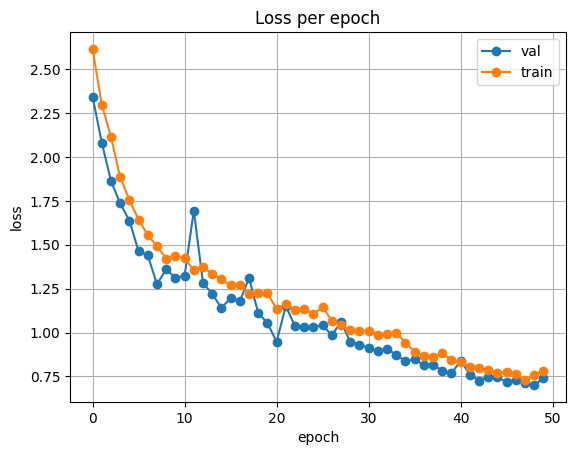

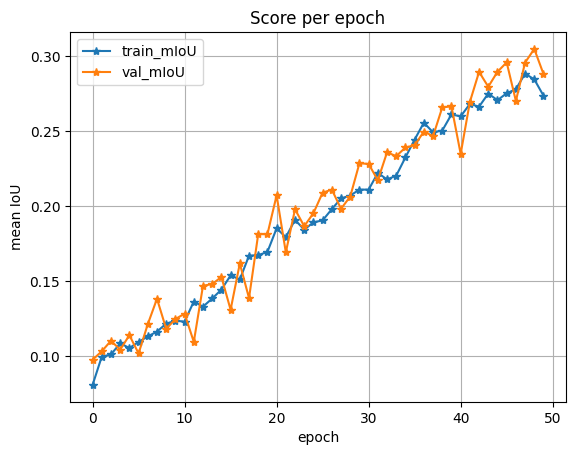

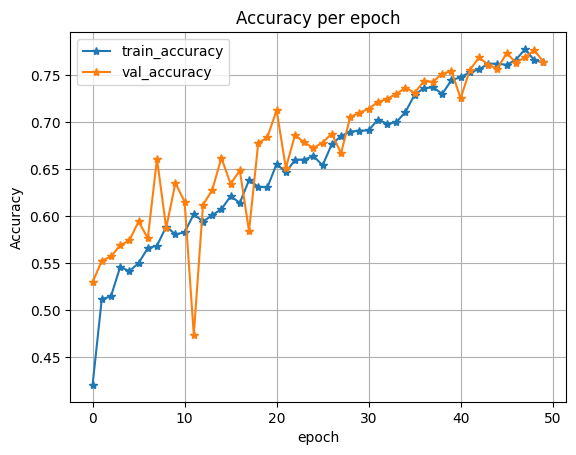

In [ ]:
torch.save(model, 'Unet-Mobilenet.pt')

def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

plot_loss(history)
plot_score(history)
plot_acc(history)

##**Evaluation**

In [ ]:
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(f"{self.img_path}/{df['id'][idx]}.jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(f"{self.mask_path}/{df['id'][idx]}.png", cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

##**Result**

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

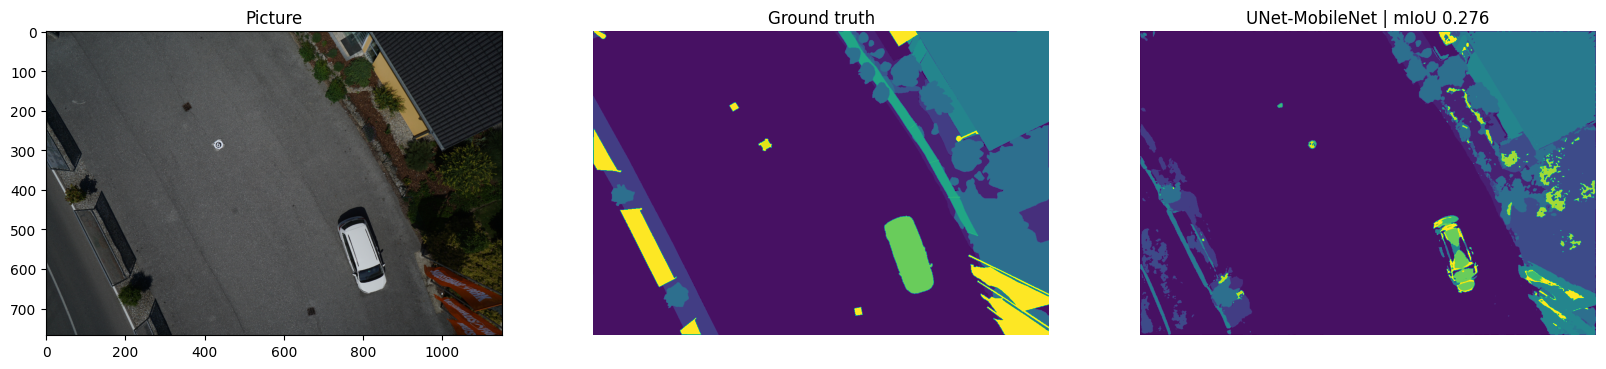

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou
mob_miou = miou_score(model, test_set)
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy
mob_acc = pixel_acc(model, test_set)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

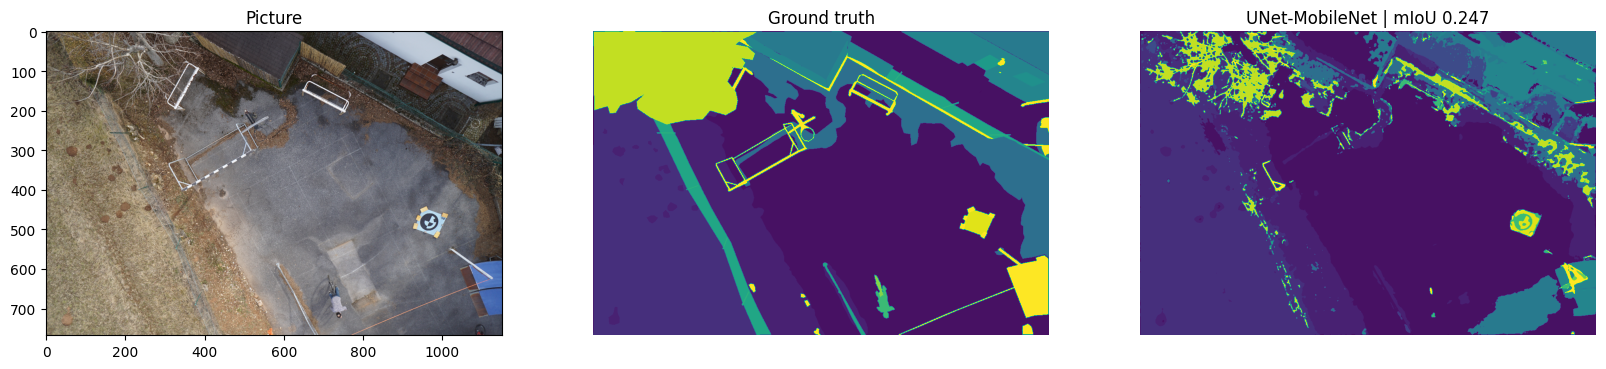

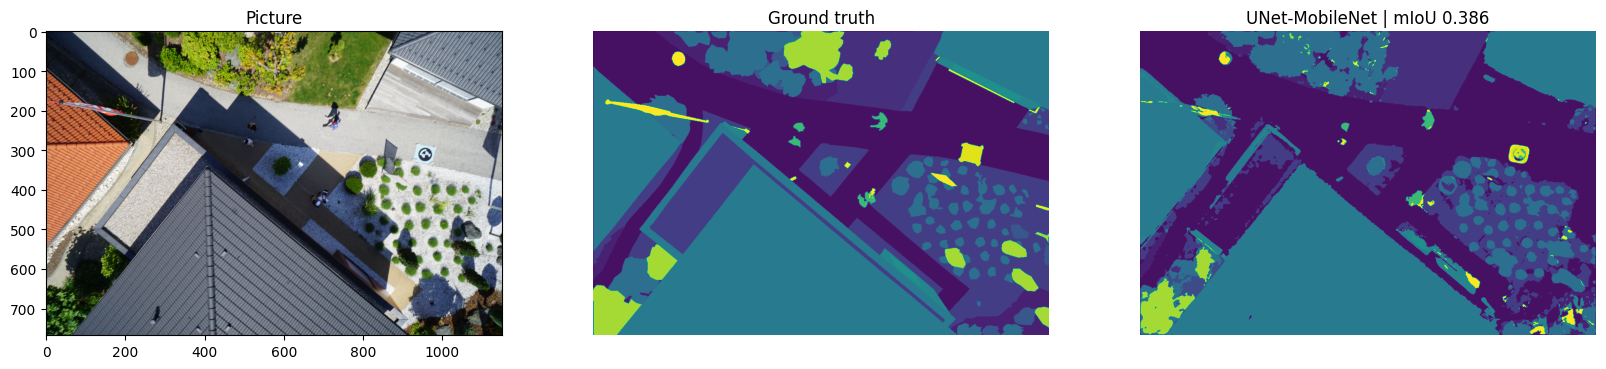

In [ ]:
image2, mask2 = test_set[15]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

image3, mask3 = test_set[9]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set mIoU 0.2792614378914887
Test Set Pixel Accuracy 0.7254838166413483
